# `Document & Tutorial`
This BEM package is used for for numerical simulating the electric field of ion traps in python style. Some external packages are wrapped in it:

* fast triangulation (http://www.cs.cmu.edu/~quake/triangle.research.html)
* fastlap boundary element method (Nabors K S. Efficient three-dimensional capacitance calculation[D]. Massachusetts Institute of Technology, 1993.)

This document, also as a tutorial, explains how to numerical computing electric field and computing its multipole expansion coefficient starting from scratch with a fusion 360 trap model(take `./f3d/htrap_overhang_9x5mm.f3d` for example). Our document consists of three .ipynb files: 

* `I_Mesh_Processing.ipynb`
* `II_Field_Simulation.ipynb`
* `III_Multipole_Expansion.ipynb`

We split the document into three files for some reasons:1. the most time consuming part `II_Field_Simulation.ipynb` could be taken out alone and run on HPC. 2.the intermediate result between files can be checked. 

Going through three files in order and running their python code will help you understand our workflow. Generally our workflow divides into three steps, corresponding to the above three .ipynb files. Firstly we identify different electrodes of the trap model by different colors. Also, we refines the trap model meshes to prepare for the second step. The result is stored in `mesh_result.pkl`. Secondly, we simulate the electric potential with fastlap boundary element method(FMM), the accuracy of this step depends on the mesh size in the first step. The result is stored in `field_result.pkl`. Thirdly, we analyze the electric field. Our focus is the multipole coefficient of the field under specific voltage distribution.

Before running codes, you must set up the environment according to instructions in `README`

notes
* Our workflow, as indicated by this document, abandons mayavi(with its embeded package tvtk). But we reserve mayavi in our Bem source code, if you want to use mayavi related functions, you must set up environment with files in`./backup/setup_with_mayavi`, just replace corresponding files in the root folder with them and set up.
    * why we abandon mayavi: because its python interface(with its dependence vtk and PyQt5) requires complex package dependencies and version controls especially for new python versions. This makes it difficult to maintain this project.
    * why we still keep mayavi in the source code? Because it is rooted in our source code deeply. We can just avoid invoke related functions instead of deleting them, because they may make sense in the future.

# `I. Mesh Processing` 
This .pynb file reads a colored model file `./inter_results/htrap.stl`, and assigns a name for each color(thus for each electrode). The result is stored in `./inter_results/mesh_result.pkl`.

In this file we name different electrodes and refine the meshes. The size of mesh deternmines the accuracy in next step. You should set the mesh finer and finer until the result converges. Also, you can set the mesh finer and test the convergence.

## (1) color your electrodes (in fusion 360) and export stl
First of all, you have a trap model in fusion 360 project, for example, `./f3d/htrap_overhang_9x5mm.f3d`.A trap always consists of different electrodes. Here we use different color to identify different electrodes(STL file stores color for each mesh). In fusion 360, you can assign different appearance for different parts, of which we only cares about the color(because stl file only stores color), not texture. We recommend to use ../../bemCol_lib/bemCol.adsklib for different electrodes. Same color for two electrodes means they are shorted. Then we get `./f3d/htrap_overhang_9x5mm_my_colored.f3d`

Then export to an stl file in fusion360 file>export tab and move the file in `./inter_results`. We export our stl in mm, so we set

In [7]:
stl_unit = 1e-3

Furthurmore, it's our convention to use unit mm in our traps. e.g. [Electric field] = V/mm , [harmonic confining potential] = V/mm^2.so we set 

In [8]:
# this is the unit for our Mesh structure
# in the following code, this is the default unit for python variables
mesh_unit = 1e-3    

Some notes:
* here we cut our trap into a smaller one, i.e. `./f3d/htrap_overhang_9x5mm_my_colored_cut.f3d`, before exporting, because distant electrode parts have little influence
* Why use standard color? We define a set of standard color lib `../../../bemCol_lib/bemCol.adsklib` for two reasons: 1. when exporting to .stl file, fusion 360 will compress 0-256 color(RGBA32) into 0-32 color(RGBA16), which means that some similar colors in fusion 360 will become same color after export to .stl file. Our standard color lib avoid this problem. 2.If you use .stl file exported from fusion 360 DIRECTLY, naming the electrodes would be very convinient. If you use other apps such as Inventor or Meshlab to generate .stl file, you can ignore the second reason because color encoding are quite different in different apps



## (2) assign a name for each color

In [9]:
import pickle
import numpy as np
import matplotlib as mpl
import sys
from bem import Electrodes, Sphere, Mesh, Grid, Configuration, Result
sys.path.append('../../helper_func')
from helper_functions import plot_mesh
# load stl geometry file
from bem.formats import stl
stl_path = "inter_results/"+"mit_LL"+".stl"  
s_nta = stl.read_stl(open(stl_path, "rb"))

Firstly, we print all the colors appear in the stl file. If a color is of standard colors in `bemCol.adsklib` or named manually by function `bemCol.set_my_color()`, then the color will appear in a straightforward name, such as `bem0`,`bem1` ...... . Otherwise, the color will simply be named as `'_unkCol0'` , `'_unkCol1'`, ... 

notes
* try to comment out the line of `ele_col.set_my_color()` in the following block, name `'_unkCol0'` will appear.

In [10]:

# print colors needs to be named
sys.path.append('../../bemCol_lib')
from bemCol import bemCol
ele_col = bemCol(np.array(list(set(s_nta[2]))),('fusion360','export_stl'))
ele_col.set_my_color(value = (178,178,178),cl_format = ('fusion360','export_stl','RGBA64'),name = 'self_defined')
ele_col.print_colors_to_name()

colors appear in the stl:
['bem6']
['bem13']
['bem19']
['bem17']
['bem11']
['bem15']
['bem1']
['bem5']
['bem12']
['bem18']
['bem3']
['bem16']
['bem7']
['bem9']
['bem4']
['bem2']
['bem20']
['bem10']
['bem14']
['bem8']
['bem21']
['_unkCol0']
22 colors in total


Next, you need to assign a name for each color appeared above. With standard colors defined in `bemCol.adsklib`, the correspondence between color and electrode is clear, which make it easy for this step. You can also comment out some `ele_col.set_color_name()`, run all the codes again and observe the missing part in the printed figure, which corresponds to the electrode you comment out. The second method also serves as a double check. Besides, parameter in `stl.stl_to_mesh()` can be set as `quiet = False` to check whether the program reads planes correctly.

dropping ['_unkCol0']
all 1 colors are dropped
dropping 20083


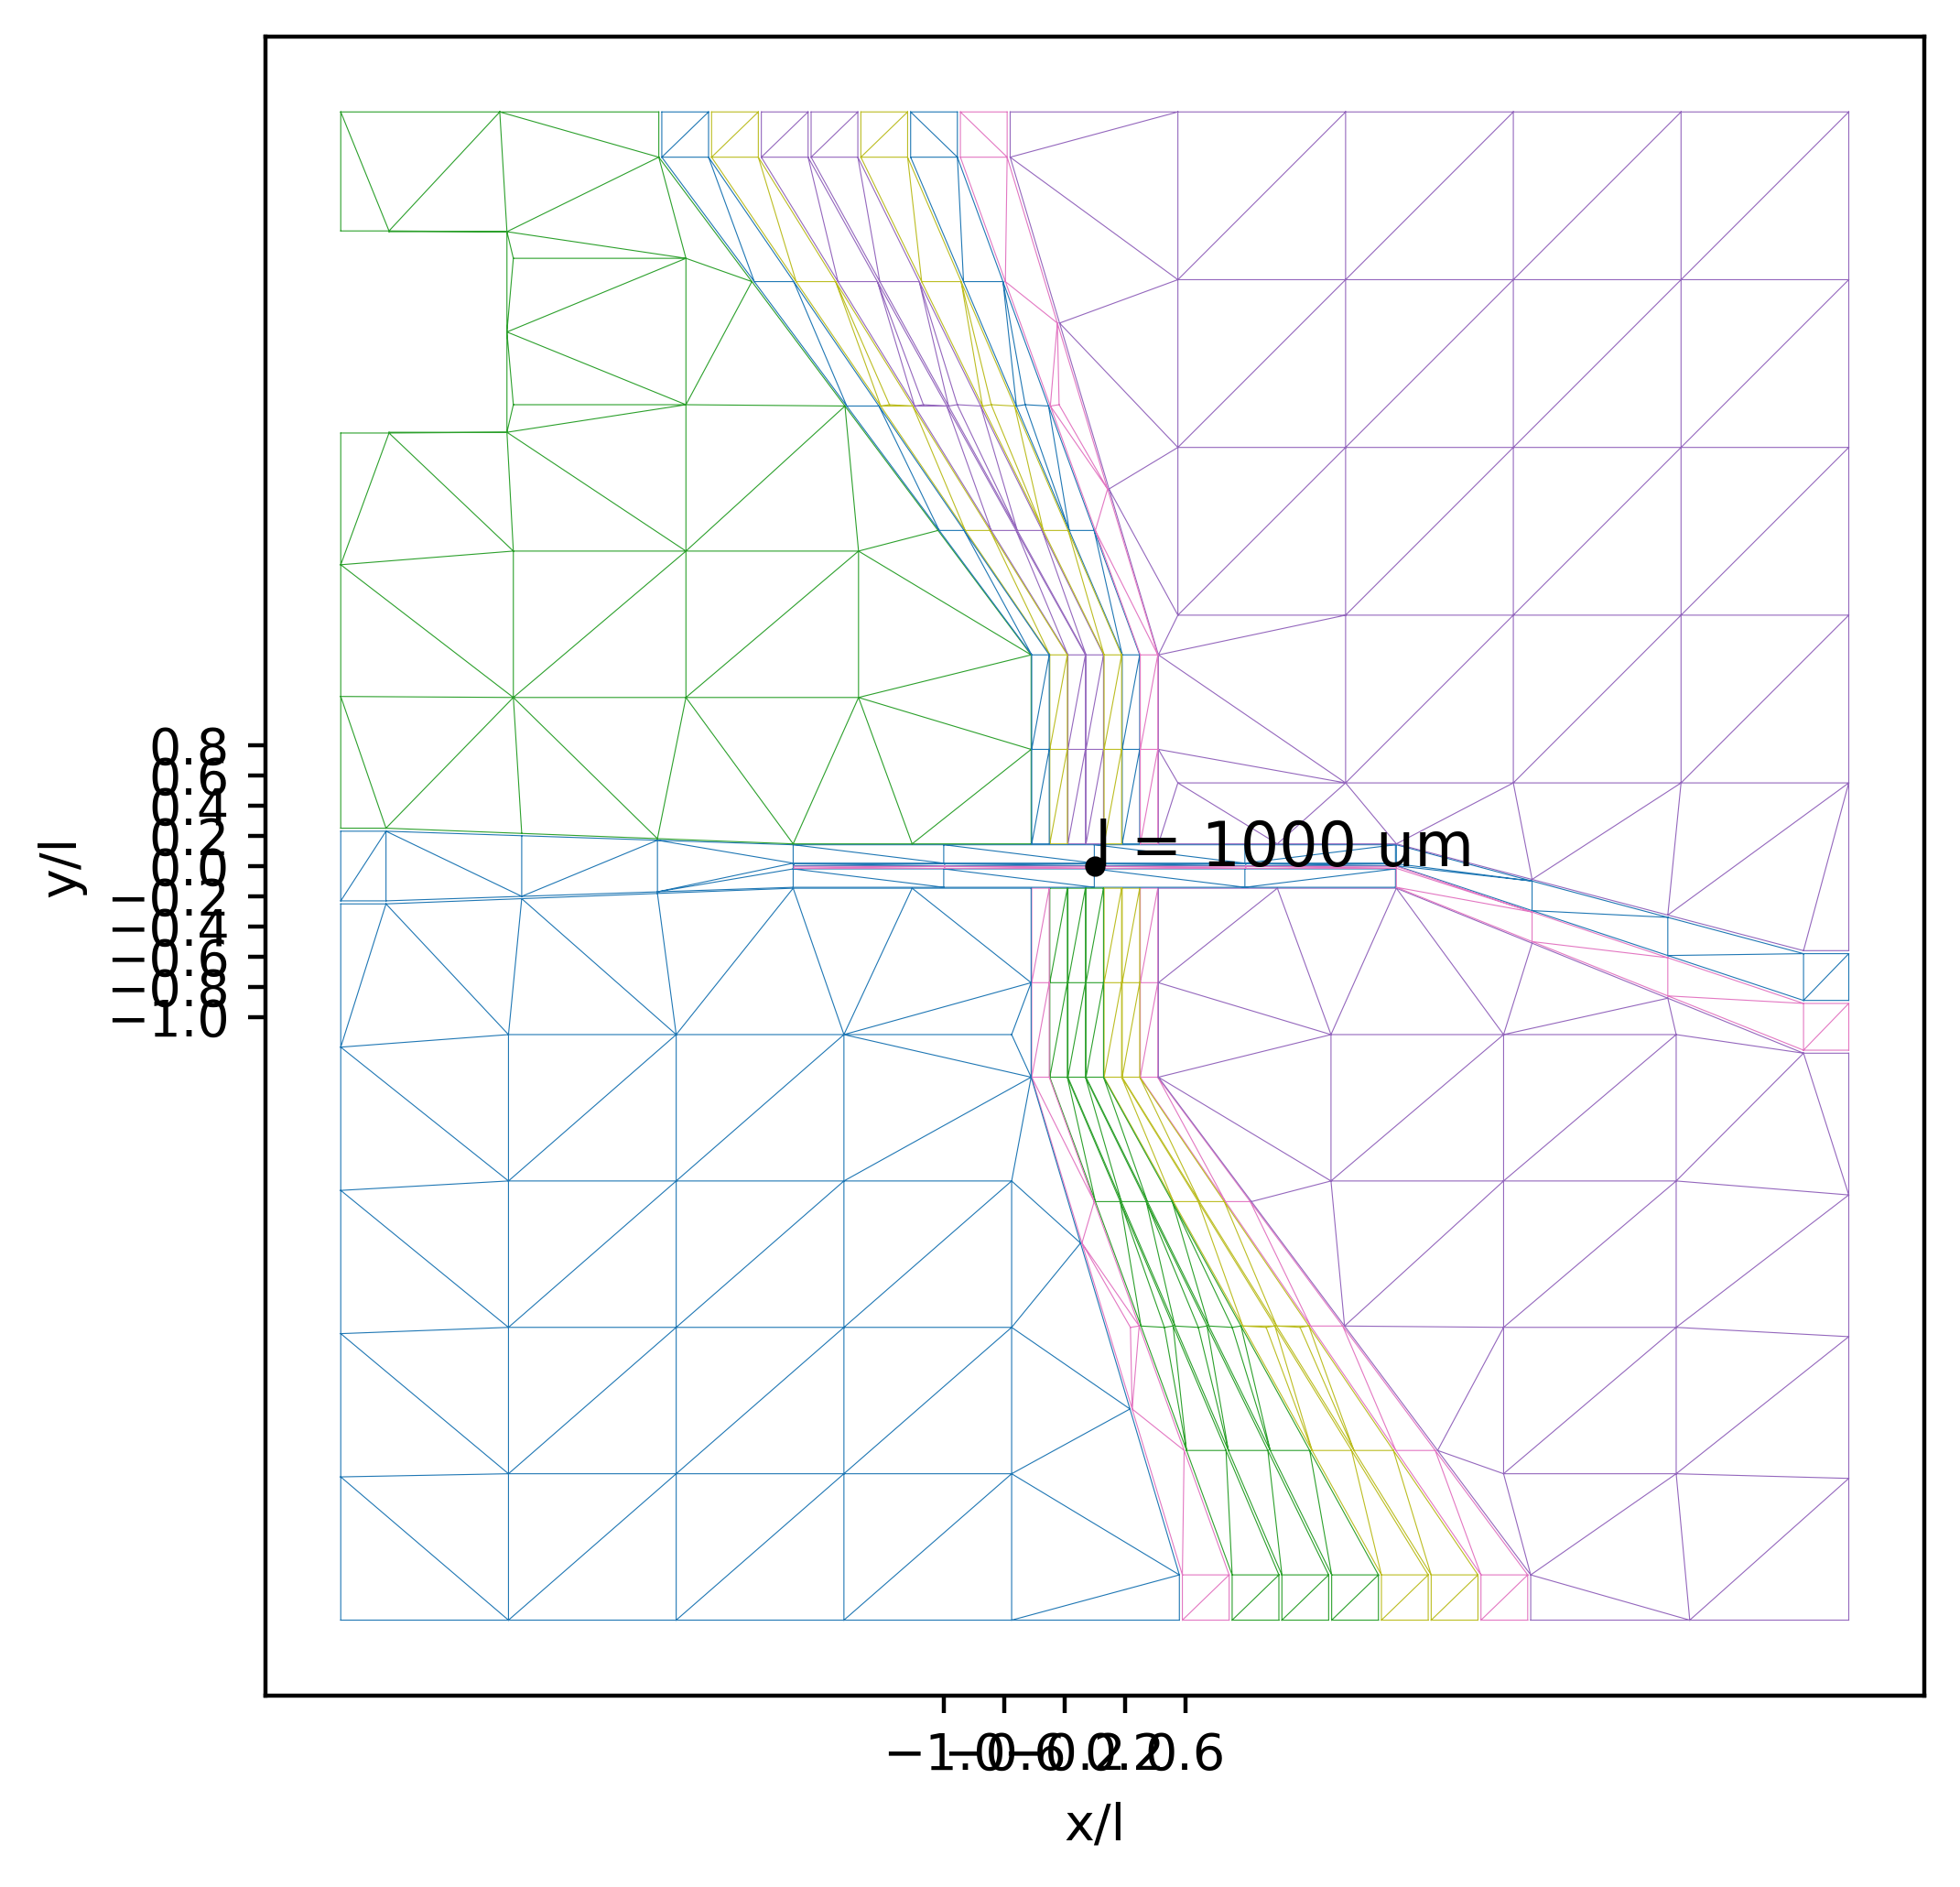

In [11]:
# assign a name for each color
ele_col.set_color_name(color = 'bem1',name = 'DC1')
ele_col.set_color_name(color = 'bem2',name = 'DC2')
ele_col.set_color_name(color = 'bem3',name = 'DC3')
ele_col.set_color_name(color = 'bem4',name = 'DC4')
ele_col.set_color_name(color = 'bem5',name = 'DC5')
ele_col.set_color_name(color = 'bem6',name = 'DC6')
ele_col.set_color_name(color = 'bem7',name = 'DC7')
ele_col.set_color_name(color = 'bem8',name = 'DC8')
ele_col.set_color_name(color = 'bem9',name = 'DC9')
ele_col.set_color_name(color = 'bem10',name = 'DC10')
ele_col.set_color_name(color = 'bem11',name = 'DC11')
ele_col.set_color_name(color = 'bem12',name = 'DC12')
ele_col.set_color_name(color = 'bem13',name = 'DC13')
ele_col.set_color_name(color = 'bem14',name = 'DC14')
ele_col.set_color_name(color = 'bem15',name = 'DC15')
ele_col.set_color_name(color = 'bem16',name = 'DC16')
ele_col.set_color_name(color = 'bem17',name = 'DC17')
ele_col.set_color_name(color = 'bem18',name = 'DC18')
ele_col.set_color_name(color = 'bem19',name = 'DC19')
ele_col.set_color_name(color = 'bem20',name = 'DC20')
# ele_col.set_color_name(color = 'bem21',name = 'DC21')
ele_col.set_color_name(color = 'bem21',name = 'RF')
# ele_col.set_color_name(color = 'bem30',name = 'DC0')
# ele_col.set_color_name(color = 'bem25',name = 'RF')

# print colors still with no name. These meshes will be neglected in the following codes
ele_col.print_drop_colors()

# read stl into mesh with electrode names
# unnamed meshes will not be imported at all
mesh = Mesh.from_mesh(stl.stl_to_mesh(*s_nta, scale=1,
    rename=ele_col.result_dict, quiet=True))

mpl.rcParams['lines.linewidth'] = 0.2 ###########

# to plot an approriate area of the trap, you have to tune the first, second and fourth parameter
plot_mesh(0,0,mesh,mesh_unit,'fig1.png')

## (3) remesh

In this step, we generate triangle mesh with constraints. The meshes are 2-dimensional triangles on the surface of electrodes. The region enclosed by constraint shape can have finer mesh. Triangulation is done by `triangle` C library. Folowing variables are all in unit `mesh_unit` now.

Our remesh strategy consists of two steps of triangulation: 
1. global triangulation without constraint. This step eliminate some long and sharp triangles by combining and dividing, and obtains a coarse grain triangulated model.
2. local triangulation with constraint. This step refines each triangles in step 1, the triangle density is defined by `mesh.areas_from_constraints

parameters in the below code block should be tuned specificly for different trap geometries.`

first triangulation:
start triangulate DC20
('final opts', 'q10Qzr')
finish triangulate DC20
start triangulate DC4
('final opts', 'q10Qzr')
finish triangulate DC4
start triangulate DC14
('final opts', 'q10Qzr')
finish triangulate DC14
start triangulate DC8
('final opts', 'q10Qzr')
finish triangulate DC8
start triangulate DC13
('final opts', 'q10Qzr')
finish triangulate DC13
start triangulate DC17
('final opts', 'q10Qzr')
finish triangulate DC17
start triangulate DC3
('final opts', 'q10Qzr')
finish triangulate DC3
start triangulate DC9
('final opts', 'q10Qzr')
finish triangulate DC9
start triangulate DC2
('final opts', 'q10Qzr')
finish triangulate DC2
start triangulate DC7
('final opts', 'q10Qzr')
finish triangulate DC7
start triangulate RF
('final opts', 'q10Qzr')
finish triangulate RF
start triangulate DC11
('final opts', 'q10Qzr')
finish triangulate DC11
start triangulate DC15
('final opts', 'q10Qzr')
finish triangulate DC15
start triangulate DC10
('final opts', 'q10Qzr')
finish tria

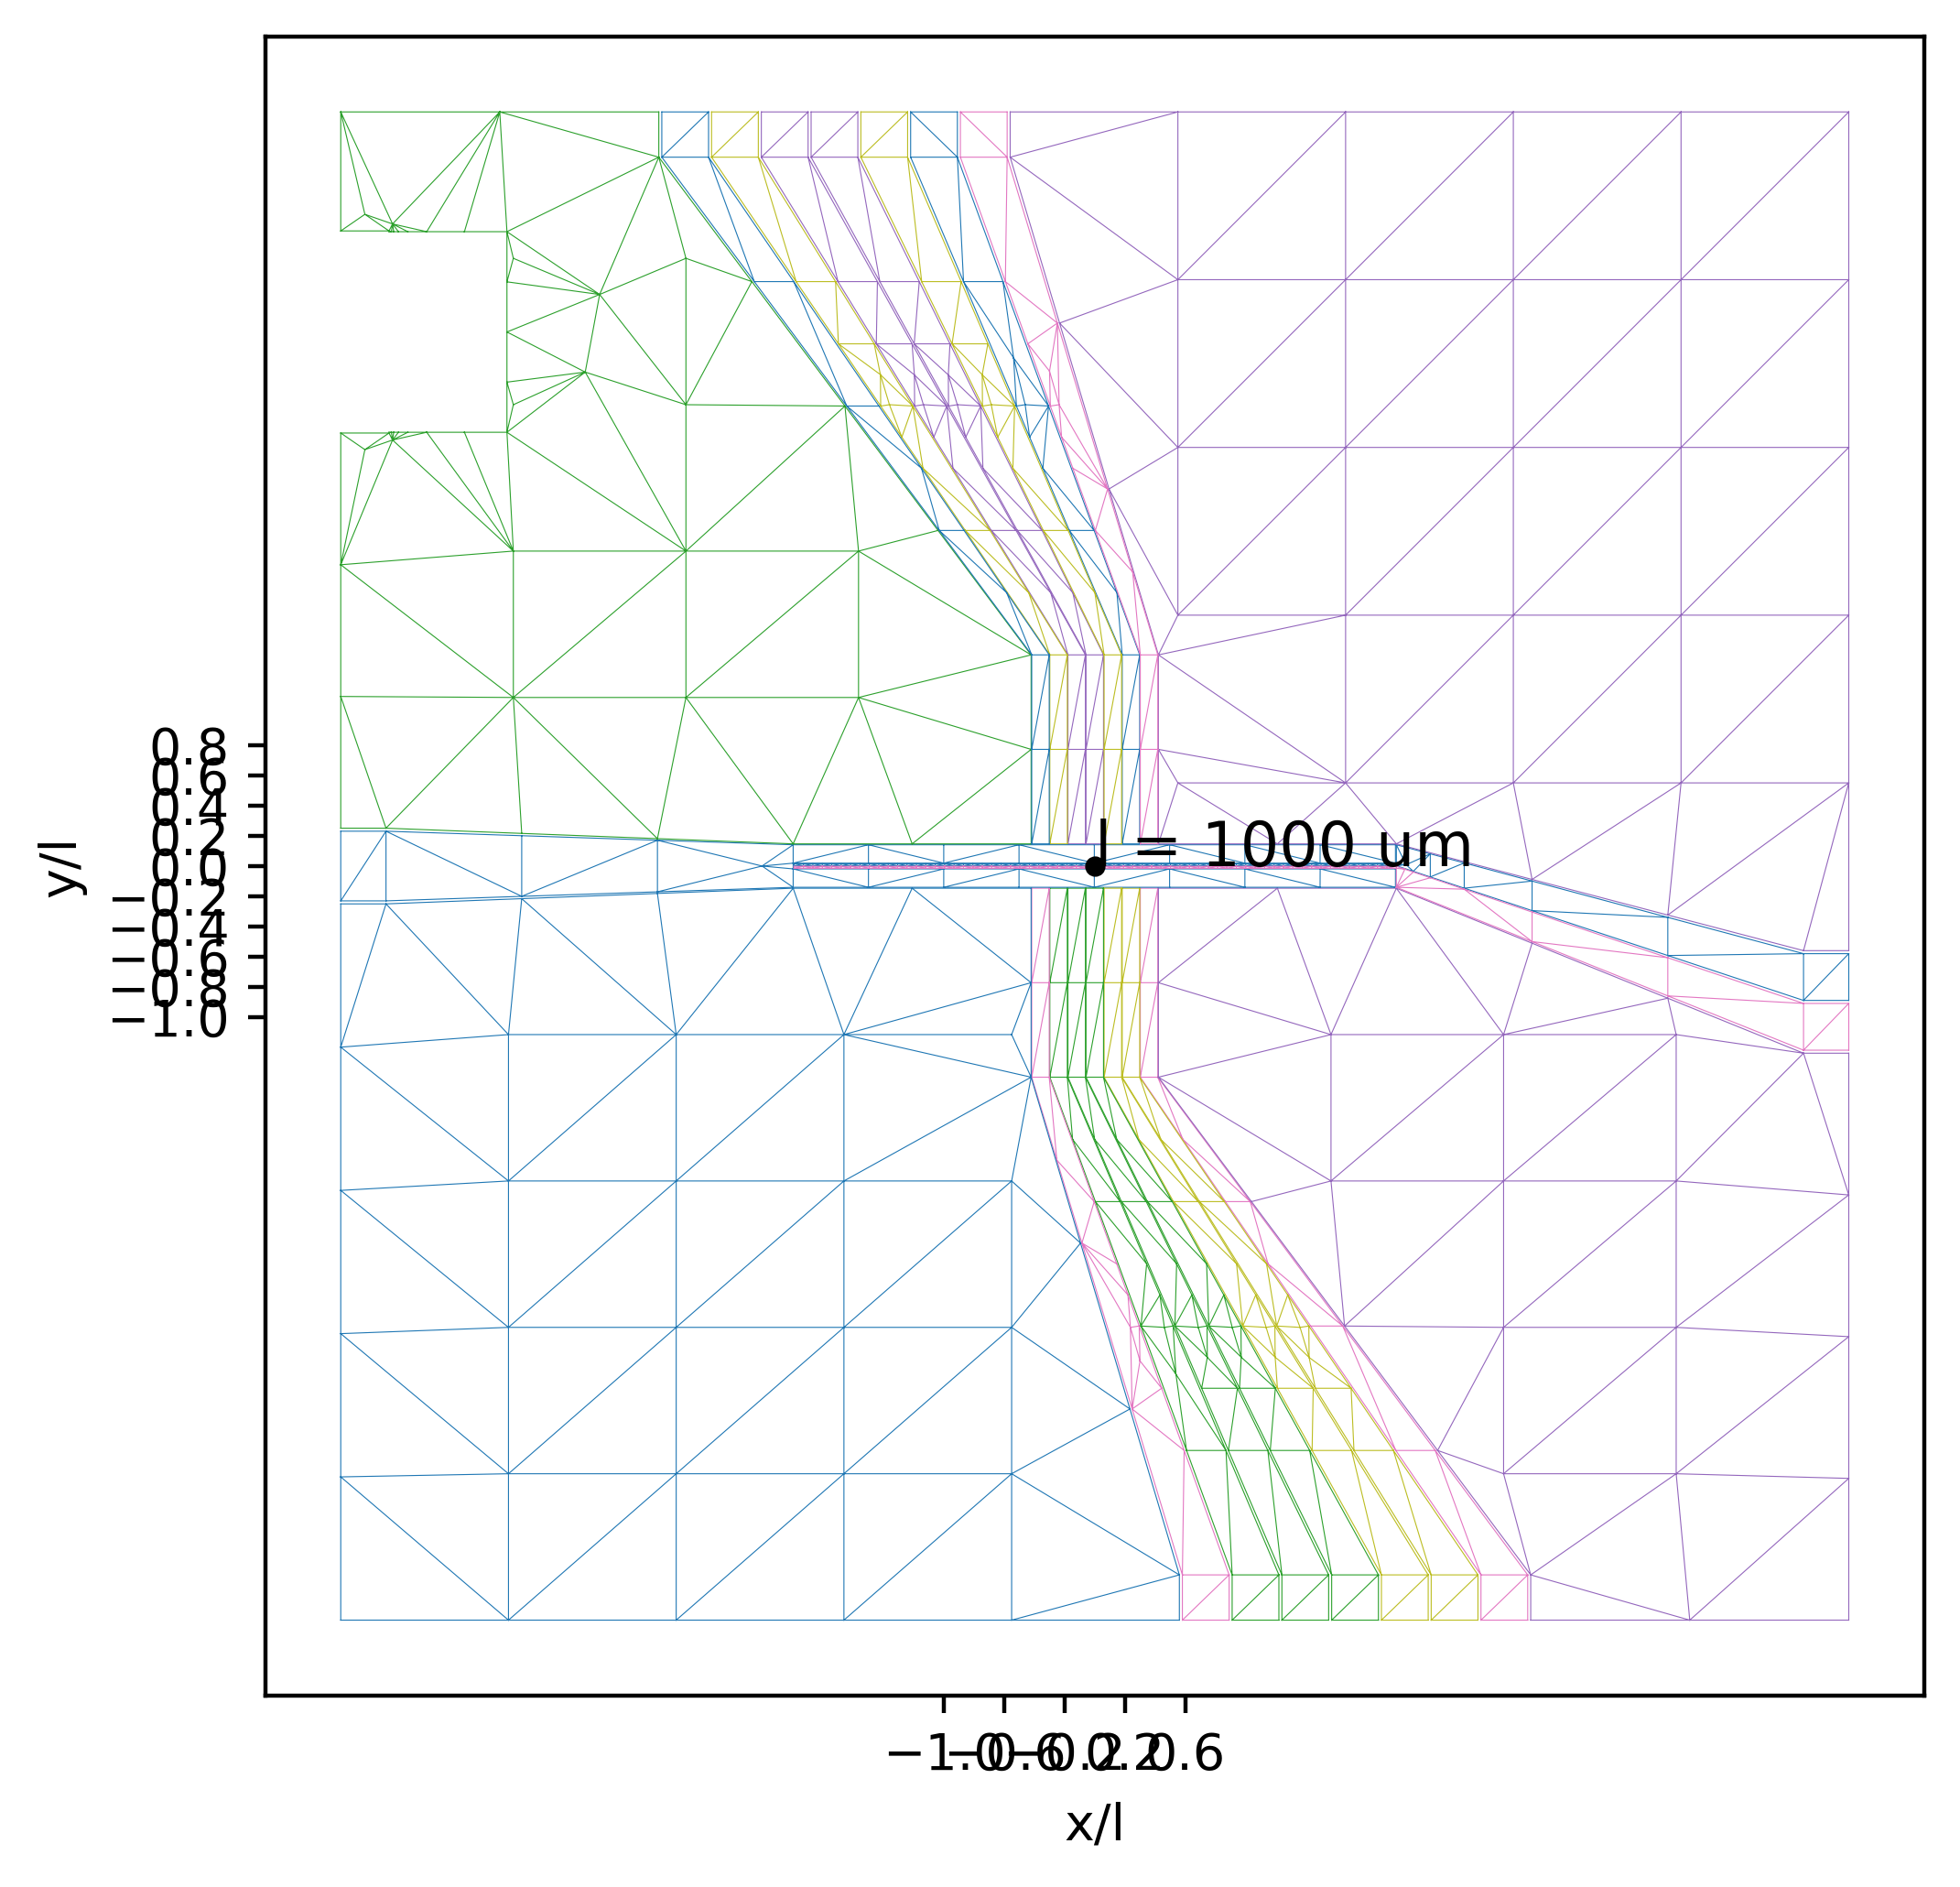

second triangulation:
start triangulate DC20
('final opts', 'q20Qzra')
finish triangulate DC20
start triangulate DC4
('final opts', 'q20Qzra')
finish triangulate DC4
start triangulate DC14
('final opts', 'q20Qzra')
finish triangulate DC14
start triangulate DC8
('final opts', 'q20Qzra')
finish triangulate DC8
start triangulate DC13
('final opts', 'q20Qzra')
finish triangulate DC13
start triangulate DC17
('final opts', 'q20Qzra')
finish triangulate DC17
start triangulate DC3
('final opts', 'q20Qzra')
finish triangulate DC3
start triangulate DC9
('final opts', 'q20Qzra')
finish triangulate DC9
start triangulate DC2
('final opts', 'q20Qzra')
finish triangulate DC2
start triangulate DC7
('final opts', 'q20Qzra')
finish triangulate DC7
start triangulate RF
('final opts', 'q20Qzra')
finish triangulate RF
start triangulate DC11
('final opts', 'q20Qzra')
finish triangulate DC11
start triangulate DC15
('final opts', 'q20Qzra')
finish triangulate DC15
start triangulate DC10
('final opts', 'q20Qzr

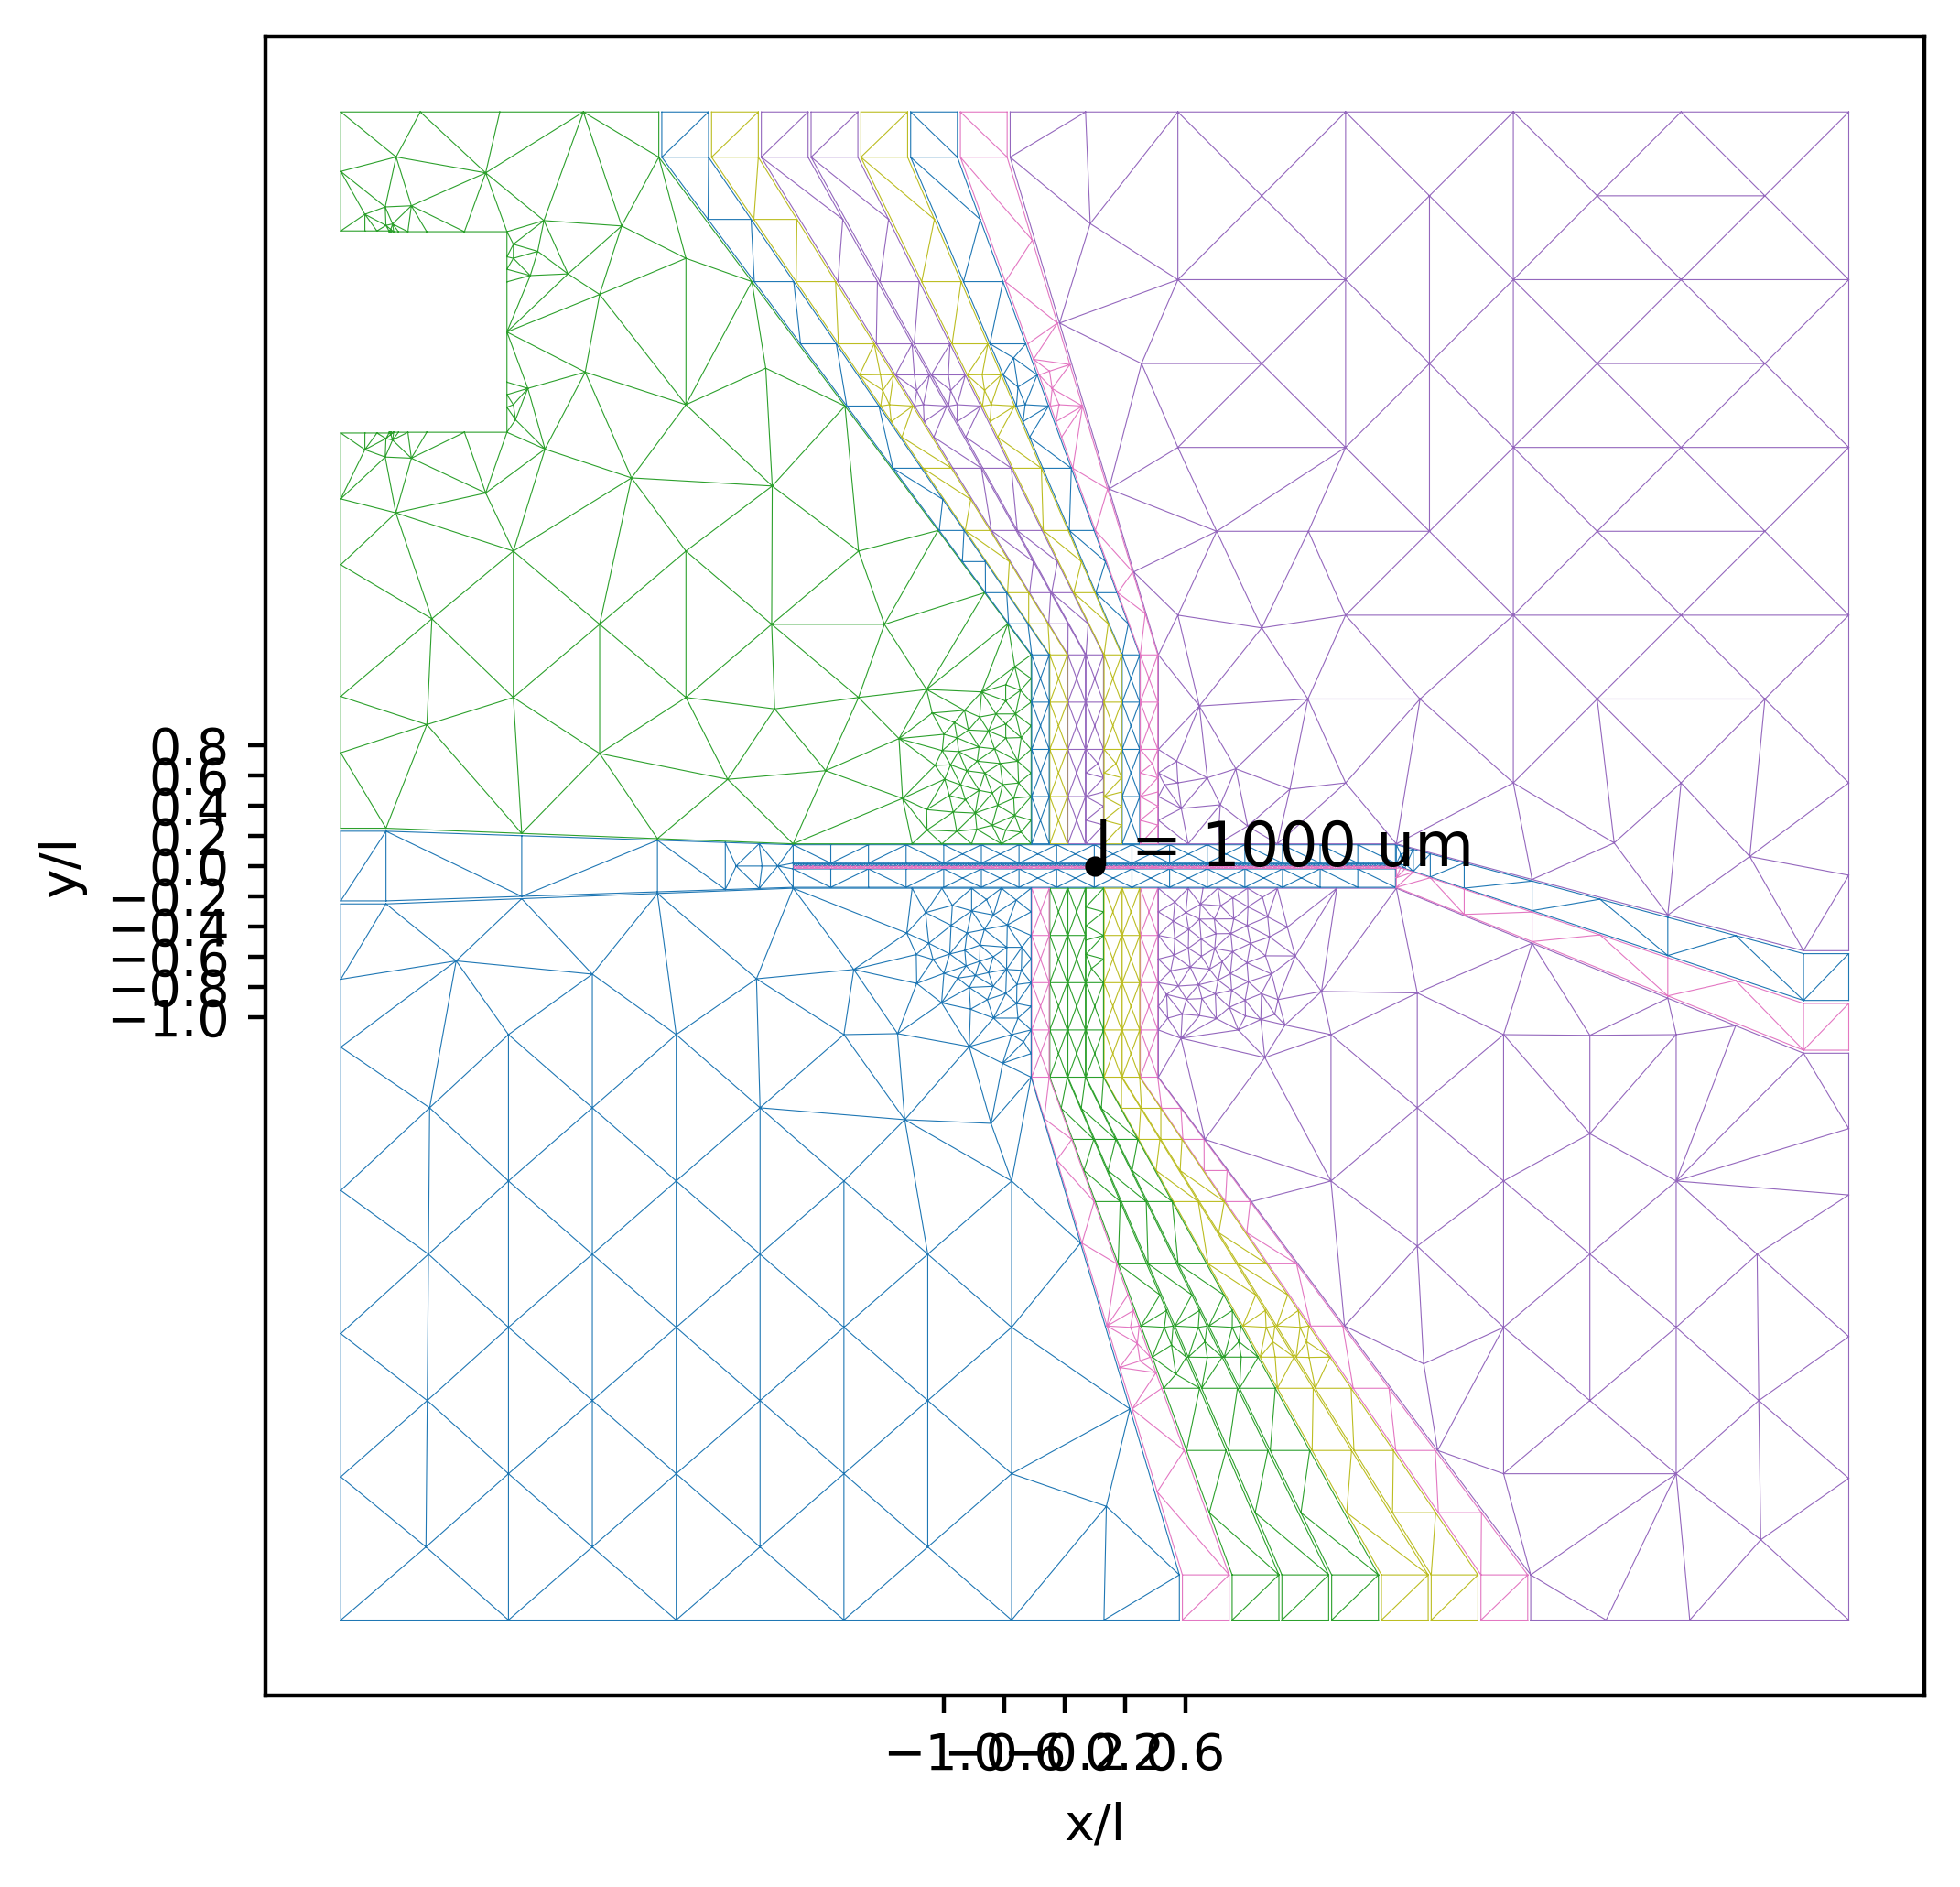

In [12]:
# here we define a spherical constriant zone:
xl = 0*1e-3
yl = 0*1e-3
zl = 50*1e-3
rad = 2000*1e-3

# inside and outside that sphere, triangle density is:
inside=1e-2
outside=4e-1

print('first triangulation:')
mesh.triangulate(opts="q10Q",new = False)
plot_mesh(xl,yl,mesh,mesh_unit,'fig2.png')

print('second triangulation:')
# areas_from_constraints specifies sphere with finer mesh inside it.
 # "inside", "outside" set different mesh densities.Q
inside=2e-2
outside=4e-1
mesh.areas_from_constraints(Sphere(center=np.array([xl,yl,zl]),radius=rad, inside=inside, outside=outside))
mesh.triangulate(opts="q20Q",new = False)
print("here")
plot_mesh(xl,yl,mesh,mesh_unit,'fig2.png')

# save base mesh to a pickle file
fout_name = './inter_results/mesh_result.pkl'
with open(fout_name,'wb') as f:
    data = (mesh_unit,
            xl,
            yl,
            zl,
            mesh)
    pickle.dump(data,f)
